In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%run setup_notebooks.py

In [3]:
from toolbox.wandb_export import process_runs

In [4]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [5]:
import wandb

In [6]:
from itertools import product

def format_metric(mean, std):
    return f'{mean:.3} ± {std:.3}'

def process_metrics(df, test_id, hyperparams, include_test=True):
    prefixes = ['val', 'train']
    if include_test:
        prefixes.insert(0, 'test')
        
    labels = [
        (tpl, '.'.join(tpl)) 
        for tpl in product(prefixes, ['f1-score', 'accuracy', 'precision', 'recall'])
    ]
    data = {
        tpl: (df[col].mean(), df[col].std()) for tpl, col in labels
    }
    data = {
        tpl: [format_metric(*vals)] for tpl, vals in data.items()
    }
    
    if len(hyperparams) > 0:
        hyp = df[hyperparams]
        assert (hyp.nunique() == 1).all()
        hyp = hyp.iloc[[0]]
        hyp.index = [test_id]
    else:
        hyp = None
    
    
    return pd.DataFrame(data, index=[test_id]), hyp

In [15]:
files = Path('data').glob('*.csv')
dfs = []
for file in files:
    df = pd.read_csv(file)
    test_id = file.stem.split('-')[-1]
    df['test_id'] = test_id
    dfs.append(df)
    
dfs = pd.concat(dfs)

In [16]:
hyperparams = [
    'dataset.name', 'epochs', 'loss.weight', 'model.name', 'model.type',
    'num_equiv', 'num_gin', 'num_hidden_dim', 'optimizer.lr'
]

In [17]:
metrics = [
    f'{t}.1.{m}'
    for t in ('test', 'val', 'train')
    for m in ('f1-score', 'precision', 'recall')
]


df = dfs.groupby('test_id').agg(['mean', 'std'])[metrics]
df

test.1.f1-score           test.1.precision           test.1.recall  \
                   mean       std             mean       std          mean   
test_id                                                                      
025ugr         0.485001  0.103084         0.383651  0.056465         0.675   
7d62ll         0.415668  0.057718         0.358205  0.047311         0.500   
bh8c7z         0.328321  0.055705         0.320606  0.034973         0.350   
d3m09i         0.420413  0.093542         0.404545  0.112940         0.450   
frhlsk         0.323126  0.202230         0.272987  0.164070         0.400   
k2evji         0.489533  0.077143         0.379595  0.042882         0.700   

                  val.1.f1-score           val.1.precision            \
              std           mean       std            mean       std   
test_id                                                                
025ugr   0.227074       0.519678  0.110350        0.422871  0.077340   
7d62ll   0.088388       0.521496  0.066603        0.459162  0.055022   
bh8c7z   0.104583       0.565293  0.112974        0.631933  0.075958   
d3m09i   0.111803       0.509096  0.135829        0.497677  0.138482   
frhlsk   0.270994       0.399419  0.248079        0.355080  0.225864   
k2evji   0.189572       0.552846  0.101840        0.438479  0.086139   

        val.1.recall           train.1.f1-score           train.1.precision  \
                mean       std             mean       std              mean   
test_id                                                                       
025ugr      0.691429  0.208586         0.612583  0.022891          0.511148   
7d62ll      0.611429  0.111351         0.840045  0.040730          0.731527   
bh8c7z      0.524762  0.146401         0.745750  0.025499          0.740147   
d3m09i      0.527619  0.145896         0.800843  0.082081          0.756142   
frhlsk      0.461905  0.283523         0.502097  0.281032          0.427122   
k2evji      0.762857  0.180589         0.633768  0.027056          0.519785   

                  train.1.recall            
              std           mean       std  
test_id                                     
025ugr   0.040648       0.785420  0.129011  
7d62ll   0.064855       0.990333  0.010731  
bh8c7z   0.041722       0.753721  0.041344  
d3m09i   0.108219       0.856518  0.063210  
frhlsk   0.240178       0.614217  0.348391  
k2evji   0.061378       0.833051  0.101193

In [18]:
df_config = []
for test_id, sub in dfs.groupby('test_id'):
    assert ((sub[hyperparams].nunique() == 1) | (sub[hyperparams].nunique() == 0)).all()
    # Pick any
    item = sub[hyperparams].iloc[0]
    df_config.append(item.rename(test_id))
    
df_config = pd.DataFrame(df_config)
df_config

,dataset.name,epochs,loss.weight,model.name,model.type,num_equiv,num_gin,num_hidden_dim,optimizer.lr
025ugr,CoordToCnc,130,0.650000,EGNN_GIN_KNN5,Equiv,3.0,0,5,0.004000
7d62ll,CoordToCnc_rot,304,0.786622,GIN_rot,GIN,NaN,7,8,0.000124
bh8c7z,WssToCnc,120,0.500000,EGNN_GIN_WSS,Equiv,3.0,0,8,0.001000
d3m09i,CoordToCnc_coarsened_r0.7_k5_NOISE4e-2,70,0.572972,EGNN_GIN_KNN5,Equiv,4.0,1,8,0.001016
frhlsk,CoordToCnc_NOISE4e-2,90,0.650000,EGNN_GIN_KNN5,Equiv,5.0,0,5,0.004000
k2evji,CoordToCnc_NOISE4e-2,90,0.650000,EGNN_GIN_KNN5,Equiv,3.0,0,8,0.004000


In [11]:
df.columns.get_level_values(0)

Index(['test.1.f1-score', 'test.1.f1-score', 'test.1.precision',
       'test.1.precision', 'test.1.recall', 'test.1.recall', 'val.1.f1-score',
       'val.1.f1-score', 'val.1.precision', 'val.1.precision', 'val.1.recall',
       'val.1.recall', 'train.1.f1-score', 'train.1.f1-score',
       'train.1.precision', 'train.1.precision', 'train.1.recall',
       'train.1.recall'],
      dtype='object')

In [12]:
def to_tex(df, float_format="{:0.2f}".format):
    metrics = df.columns.get_level_values(0)
    out = dict()
    for tid, row in df.iterrows():
        resrow = {
            m: f"{row[(m, 'mean')]:.3} ± {row[(m, 'std')]:.3}"
            for m in metrics
        }
        out[tid] = resrow
    
    out = pd.DataFrame(out).T
    tex = out.to_latex()
    tex = tex.replace('midrule', 'hline').replace('toprule', 'hline').replace('bottomrule', 'hline')
    return tex

In [19]:
print(to_tex(df))

\begin{tabular}{llllllllll}
\hline
{} & test.1.f1-score & test.1.precision &  test.1.recall &  val.1.f1-score & val.1.precision &   val.1.recall & train.1.f1-score & train.1.precision &  train.1.recall \\
\hline
025ugr &   0.485 ± 0.103 &   0.384 ± 0.0565 &  0.675 ± 0.227 &     0.52 ± 0.11 &  0.423 ± 0.0773 &  0.691 ± 0.209 &   0.613 ± 0.0229 &    0.511 ± 0.0406 &   0.785 ± 0.129 \\
7d62ll &  0.416 ± 0.0577 &   0.358 ± 0.0473 &   0.5 ± 0.0884 &  0.521 ± 0.0666 &   0.459 ± 0.055 &  0.611 ± 0.111 &    0.84 ± 0.0407 &    0.732 ± 0.0649 &   0.99 ± 0.0107 \\
bh8c7z &  0.328 ± 0.0557 &    0.321 ± 0.035 &   0.35 ± 0.105 &   0.565 ± 0.113 &   0.632 ± 0.076 &  0.525 ± 0.146 &   0.746 ± 0.0255 &     0.74 ± 0.0417 &  0.754 ± 0.0413 \\
d3m09i &   0.42 ± 0.0935 &    0.405 ± 0.113 &   0.45 ± 0.112 &   0.509 ± 0.136 &   0.498 ± 0.138 &  0.528 ± 0.146 &   0.801 ± 0.0821 &     0.756 ± 0.108 &  0.857 ± 0.0632 \\
frhlsk &   0.323 ± 0.202 &    0.273 ± 0.164 &    0.4 ± 0.271 &   0.399 ± 0.248 &   0.355 ± 0

In [14]:
dfs[metrics + ["test_id", 'Name']]

,test.1.f1-score,test.1.precision,test.1.recall,val.1.f1-score,val.1.precision,val.1.recall,train.1.f1-score,train.1.precision,train.1.recall,test_id,Name
0,0.333333,0.300000,0.375,0.562500,0.500000,0.642857,0.583333,0.564516,0.603448,025ugr,fold-3
1,0.454545,0.357143,0.625,0.564103,0.458333,0.733333,0.593548,0.469388,0.807018,025ugr,fold-2
2,0.615385,0.444444,1.000,0.577778,0.433333,0.866667,0.635838,0.474138,0.964912,025ugr,fold-1
3,0.500000,0.416667,0.625,0.322581,0.294118,0.357143,0.628571,0.536585,0.758621,025ugr,fold-5
4,0.521739,0.400000,0.750,0.571429,0.428571,0.857143,0.621622,0.511111,0.793103,025ugr,fold-4
0,0.352941,0.333333,0.375,0.628571,0.550000,0.733333,0.806818,0.677804,0.996491,7d62ll,fold-2
1,0.400000,0.333333,0.500,0.516129,0.470588,0.571429,0.884013,0.810345,0.972414,7d62ll,fold-4
2,0.444444,0.400000,0.500,0.451613,0.437500,0.466667,0.885093,0.793872,1.000000,7d62ll,fold-1
3,0.500000,0.416667,0.625,0.484848,0.421053,0.571429,0.814710,0.690647,0.993103,7d62ll,fold-3
4,0.380952,0.307692,0.500,0.526316,0.416667,0.714286,0.809591,0.684964,0.989655,7d62ll,fold-5


# Explore predictions

In [113]:
df = pd.read_json('data/pred-3eyu0aga.json')
df

,file,type,g_x,pred,y
0,CHUV01_LAD.pt,train,"[[1.0, 0.0, 0.0]]","[0.20732200145721402, 0.7926779389381401]",0
1,CHUV01_LCX.pt,train,"[[0.0, 1.0, 0.0]]","[0.6452839970588681, 0.35471603274345404]",1
2,CHUV03_LAD.pt,train,"[[1.0, 0.0, 0.0]]","[0.072567626833915, 0.9274323582649231]",1
3,CHUV03_LCX.pt,train,"[[0.0, 1.0, 0.0]]","[0.82975548505783, 0.17024452984333002]",0
4,CHUV03_RCA.pt,train,"[[0.0, 0.0, 1.0]]","[0.5003668665885921, 0.499633133411407]",0
...,...,...,...,...,...
183,OLV041_LAD.pt,test,"[[1.0, 0.0, 0.0]]","[0.172797843813896, 0.8272021412849421]",0
184,OLV041_LCX.pt,test,"[[0.0, 1.0, 0.0]]","[0.86091148853302, 0.139088556170463]",0
185,OLV041_RCA.pt,test,"[[0.0, 0.0, 1.0]]","[0.41511708498001104, 0.584882915019989]",1
186,OLV048_LAD.pt,test,"[[1.0, 0.0, 0.0]]","[0.083544924855232, 0.9164550304412841]",1


In [114]:
from sklearn.metrics import roc_curve

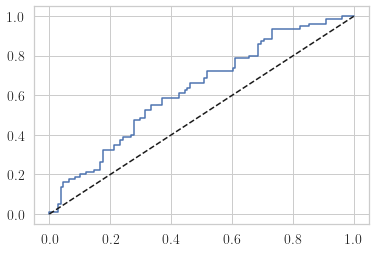

In [126]:
fpr, tpr, thres = roc_curve(df.y, df.pred.apply(lambda e: e[1]))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--k');